# MNIST classification with CNN
Compare how well a CNN performs as a classification model using the MNIST data. It is expected to perform much better than the ANN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Load data
Load in MNIST data

In [2]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

# Create data loaders
# start bs small to explore, then go bigger if we can handle
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

### Build model
Start by building convolutional layers. This is purely demonstrative to show how the stages interact. We will combine all of these into a single class, representing the NN, later.

In [3]:
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
# 1 input channel - 1 color channel, grayscale
# 6 output channels - used for feature extraction. Called "feature maps", these are the filters the CNN will figure out for us
# kernel size = 3 -> 3x3 filters
# stride length of 1

conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
# conv2 takes results of conv1 after it's passed thru a pooling layer
# 6 inputs - 6 filters from conv1
# 16 outputs - arbitrary choice of filters for conv2

In [4]:
# Grab very first batch of data
for i, (X_train,y_train) in enumerate(train_data):
    break

# We want X_train to represent a batch of 1 image --> 4D, representing a vector like (bs, channels, l, w)
X = X_train.view(1,1,28,28)

X.shape

torch.Size([1, 1, 28, 28])

In [5]:
# Perform first convolution, and pass through activation function
X = F.relu(conv1(X))
X.shape
# We're fine not having padding, and thus losing information on the edges of images since all MNIST images are centered

torch.Size([1, 6, 26, 26])

In [6]:
# Pass X through pooling layer. Select max pooling in 2D
X = F.max_pool2d(X, 2, 2)  # args of input, kernel size and stride
X.shape
# 2x2 kernel with stride of 2 cuts the size of the image in half!

torch.Size([1, 6, 13, 13])

In [7]:
# Pass X through second conv layer
X = F.relu(conv2(X))
X.shape

torch.Size([1, 16, 11, 11])

In [8]:
# Pass X through final pooling layer
X = F.max_pool2d(X, 2, 2)
X.shape

torch.Size([1, 16, 5, 5])

In [9]:
# Flatten X to pass into fully connected layer. Output layer will have 10 neurons, 1 for each class
X.view(-1,16*5*5).shape

torch.Size([1, 400])

In [10]:
# Build CNN class
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        # We don't define pooling "layers" as layers. Instead, we treat them as functions, similar to an activation function, so they get added in the forward method
        self.fc1 = nn.Linear(5*5*16,120)  # arbitrary choice of # of fc layers, and neurons in each layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)  # 2x2 kernel, stride of 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

# Instantiate model
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
# See how many parameters we've reduced to (from 100k+)
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [12]:
# Define loss fn and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
 # Set up model training
import time
start = time.time()

# Vars
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop for epochs
for e in range(epochs):
    trn_correct = 0
    tst_correct = 0
    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        # note we don't need to flatten out training data since the first conv layer (Conv2d) expects 2D data!
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr

        optimizer.zero_grad()  # find maximums
        loss.backward()  # backpropagate
        optimizer.step()  # update weights and biases

        if b%500 == 0:
            print(f'Epoch: {e} | Batch: {b} | Loss: {loss.item()}')
    
    train_losses.append(loss)
    train_correct.append(trn_correct)

    # Test
    # Use model to evaluate test data, but don't update weights and biases
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_correct += batch_corr
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)

elapsed = time.time() - start
print(f'Model training took {round(elapsed/60, 2)} minutes!')

Epoch: 0 | Batch: 500 | Loss: 0.6277940273284912
Epoch: 0 | Batch: 1000 | Loss: 0.03605744615197182
Epoch: 0 | Batch: 1500 | Loss: 0.05550842359662056
Epoch: 0 | Batch: 2000 | Loss: 0.007933182641863823
Epoch: 0 | Batch: 2500 | Loss: 0.026417383924126625
Epoch: 0 | Batch: 3000 | Loss: 0.2927563786506653
Epoch: 0 | Batch: 3500 | Loss: 0.016042783856391907
Epoch: 0 | Batch: 4000 | Loss: 0.042500000447034836
Epoch: 0 | Batch: 4500 | Loss: 0.019636245444417
Epoch: 0 | Batch: 5000 | Loss: 0.0462556853890419
Epoch: 0 | Batch: 5500 | Loss: 0.2734230160713196
Epoch: 0 | Batch: 6000 | Loss: 0.09312164783477783
Epoch: 1 | Batch: 500 | Loss: 0.19210967421531677
Epoch: 1 | Batch: 1000 | Loss: 0.003070473438128829
Epoch: 1 | Batch: 1500 | Loss: 0.03893696516752243
Epoch: 1 | Batch: 2000 | Loss: 0.00839301384985447
Epoch: 1 | Batch: 2500 | Loss: 0.3736547529697418
Epoch: 1 | Batch: 3000 | Loss: 0.078346386551857
Epoch: 1 | Batch: 3500 | Loss: 0.0028540105558931828
Epoch: 1 | Batch: 4000 | Loss: 0.09

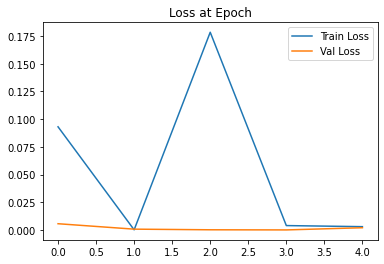

In [19]:
# Plot train losses and test losses
# Train
plt.plot([el.item() for el in train_losses], label='Train Loss')
# Test/val
plt.plot([el.item() for el in test_losses], label='Val Loss')
plt.title('Loss at Epoch')
plt.legend()

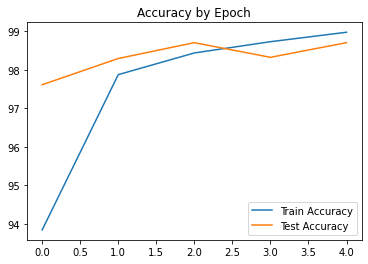

In [21]:
# Plot accuracy
# Train
plt.plot([el.item()/600 for el in train_correct], label='Train Accuracy')
# Test/val
plt.plot([el.item()/100 for el in test_correct], label='Test Accuracy')
plt.title('Accuracy by Epoch')
plt.legend()

In [22]:
# Evaluate all test data
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test,y_test in test_load_all:
        pred = model(X_test)
        predicted = torch.max(pred,1)[1]
        correct += (predicted == y_test).sum()

In [25]:
acc = (correct.item())/100
print(f'Model prediction accuracy of {acc}%!')

Model prediction accuracy of 98.7%!


In [28]:
# Confusion matrix
confusion_matrix(y_test, predicted)

array([[ 978,    0,    1,    0,    0,    0,    0,    1,    0,    0],
       [   5, 1128,    0,    0,    0,    0,    0,    0,    2,    0],
       [   1,    0, 1026,    0,    0,    0,    1,    3,    1,    0],
       [   0,    0,    4, 1002,    0,    1,    0,    1,    2,    0],
       [   0,    1,    1,    0,  976,    0,    0,    1,    0,    3],
       [   2,    0,    0,    3,    0,  883,    1,    0,    2,    1],
       [  16,    3,    2,    0,    5,    4,  927,    0,    1,    0],
       [   1,    1,    4,    0,    0,    1,    0, 1017,    2,    2],
       [   4,    0,    4,    2,    0,    0,    0,    0,  962,    2],
       [   4,    2,    1,    2,    9,    2,    0,    7,   11,  971]],
      dtype=int64)

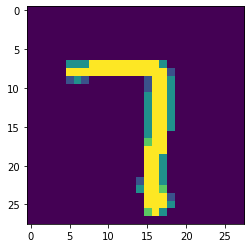

In [33]:
# Run a single image through the model
plt.imshow(test_data[370][0].reshape(28,28))

In [36]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[370][0].view(1,1,28,28))  # bs, color channel, l, w
print(f'Predicted value is {new_pred.argmax().item()}')

Predicted value is 7
